### Collecting data

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('CamData', 'data', 'images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [7]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\micha\.labelmerc


### Augmented data

In [8]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [10]:
images = tf.data.Dataset.list_files('CamData\\data\\images\\*.jpg')
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img
images = images.map(load_image)

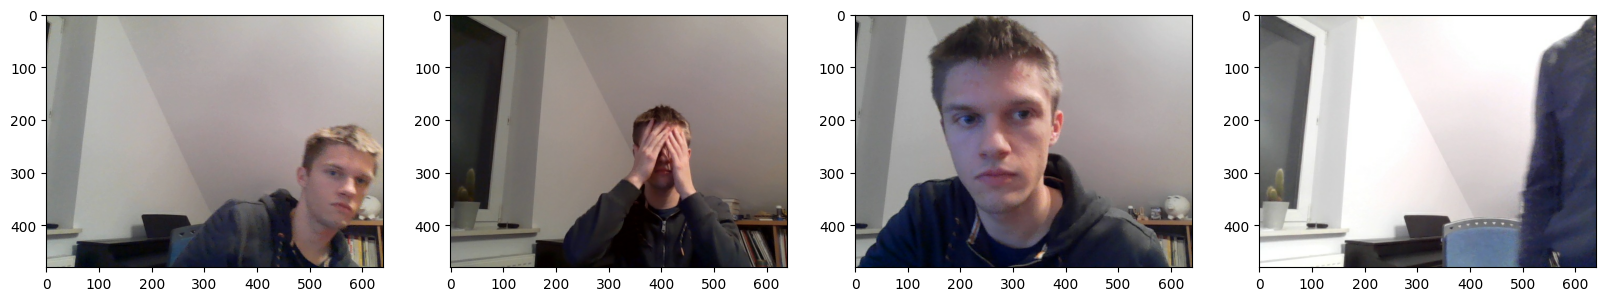

In [13]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [15]:
120*.7 # 84 to train
120*.15 # 18 to validate and test

18.0

In [17]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('CamData', 'data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('CamData', 'data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('CamData', 'data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

### Augmenting data

In [18]:
import albumentations as alb

In [19]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [21]:
img = cv2.imread(os.path.join('CamData', 'data','train', 'images','0efe9071-7fdd-11ee-b2b1-ec773ba9cb5a.jpg'))
with open(os.path.join('CamData', 'data', 'train', 'labels', '0efe9071-7fdd-11ee-b2b1-ec773ba9cb5a.json'), 'r') as f:
    label = json.load(f)
label['shapes'][0]['points']

[[343.05555555555554, 145.83333333333334],
 [493.61111111111114, 324.72222222222223]]

In [22]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords
img_width = 640
img_height = 480
coords = list(np.divide(coords, [img_width,img_height,img_width,img_height]))
coords

[0.5360243055555556,
 0.3038194444444445,
 0.7712673611111112,
 0.6765046296296297]

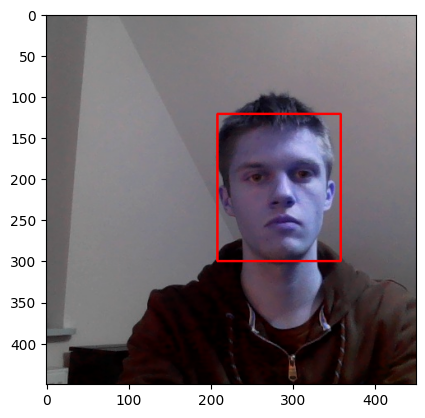

In [23]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented['bboxes'][0][2:]
augmented['bboxes']
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

#### Pipeline

In [25]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('CamData', 'data', partition, 'images')):
        img = cv2.imread(os.path.join('CamData', 'data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('CamData', 'data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [img_width,img_height,img_width,img_height]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('CamData', 'AugData', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('CamData', 'AugData', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)